# ITR: visualizing and explore seen as graphs

**Tangxiaoxue Zhang**

## Method's Current Usage

Recent work uses “networks” in two closely related ways in memorability research: (a) neural networks as predictive models and (b) graphs as structured representations that explicitly encode relationships among units (objects, events, or concepts). A good example of (a) is Xu et al. (2021) who introduce a contextual event memory network (CEMNet) to predict item-wise event memorability from multimodal cues (image content + contextual/semantic features extracted from lifelogging data). Their setup emphasizes that memorability is not just “in the image,” but also in contextual structure—the same cue can be more or less memorable depending on surrounding event information and semantic signals.  

A more explicitly structured approach appears in Banna et al. (2023), who propose GEMM, described as a graph-embedded memorability model (peer-reviewed conference publication). Even when a paper’s downstream predictor is a neural model, the graph framing matters because it encourages researchers to treat an image as a set of entities and relations (e.g., objects connected by co-occurrence or relational edges), rather than a single dense vector. This is closely aligned with the “images-as-structure” intuition behind scene graphs and object-centric reasoning.  

Finally, Dumont et al. (2023) propose a modular memorability network (M3-S) with components that mirror stages such as encoding, scene understanding, event understanding, and consolidation. While it is not a “graph algorithm” per se, it is strongly “network-thinking”: memorability is modeled as passing through multiple representational bottlenecks, and the authors compare learned representations via ablations to argue that different “stages” contribute differently to prediction.  

Together, these papers suggest a practical takeaway for my project: building a concept network (nodes = concepts/images; edges = similarity/interaction weights) is not just visualization—it is a way to encode a theory of how memorability relates to relational structure (semantic neighborhoods, interference, co-occurrence), and it naturally sets me up for later community detection once my graph becomes dense enough.

## Test on my data

### Draw network

In [1]:
import json
with open('data/cluster_weapon_memorability.json', "r") as f:
    memorabilty_lst = json.load(f)

from collections import defaultdict
sums = defaultdict(float)
counts = defaultdict(int)

for d in memorabilty_lst:
    for k, v in d.items():
        if isinstance(v, (int, float)):
            sums[k] += v
            counts[k] += 1

means = {k: sums[k] / counts[k] for k in sums}
print(means)

{'gun': 0.8852131565411886, 'landmine': 0.8444712410370508, 'gun+landmine': 0.8558021187782288, 'lighter': 0.8817236026128134, 'gun+lighter': 0.8746702720721563, 'flamethrower': 0.6966725736856461, 'gun+flamethrower': 0.7789110094308853, 'dynamite': 0.8759408195813497, 'gun+dynamite': 0.8608883370955785, 'fire': 0.7258027195930481, 'gun+fire': 0.7579904993375143, 'firecracker': 0.862868512670199, 'gun+firecracker': 0.86058442791303, 'firetruck': 0.7463883310556412, 'gun+firetruck': 0.7594428112109503, 'fireworks': 0.7542585035165151, 'gun+fireworks': 0.8300059735774994, 'solar_panel': 0.8303876221179962, 'gun+solar_panel': 0.8484509140253067, 'extinguisher': 0.8947333494822184, 'gun+extinguisher': 0.8951350798209509, 'cannon': 0.8285634368658066, 'gun+cannon': 0.8225803623596827, 'fire_alarm': 0.8788973838090897, 'gun+fire_alarm': 0.8736861646175385, 'bulldozer': 0.7239192227522532, 'gun+bulldozer': 0.7245373179515203, 'blowtorch': 0.879226878285408, 'gun+blowtorch': 0.8637200792630514

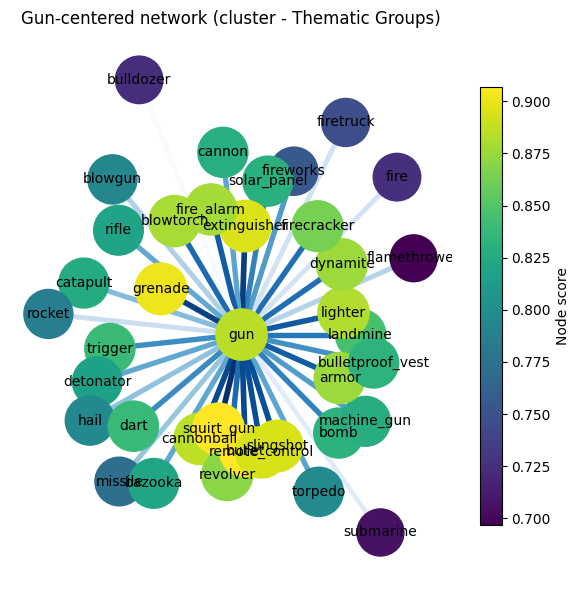

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# ---- Input data ----
center = "gun"

# ---- Split into node scores and pair scores ----
node_scores = {k: v for k, v in means.items() if "+" not in k}
pair_scores = {}
for k, v in means.items():
    if "+" in k:
        a, b = k.split("+")
        pair_scores[(a, b)] = v

# ---- Build the graph ----
G = nx.Graph()

# Add nodes with their scores
for node, score in node_scores.items():
    G.add_node(node, score=score)

# Add edges with weights (combination scores)
for (a, b), score in pair_scores.items():
    # Only add if both endpoints exist as nodes
    if a in G.nodes and b in G.nodes:
        G.add_edge(a, b, weight=score)

# ---- Compute positions ----
positions = {}

# Center node fixed at origin
positions[center] = (0.0, 0.0)

other_nodes = [n for n in node_scores.keys() if n != center]
n_others = len(other_nodes)
angles = np.linspace(0, 2 * np.pi, n_others, endpoint=False)

# Choose a global scale so distances are visible
R_MAX = 2.0  # you can tweak this

for angle, node in zip(angles, other_nodes):
    # Get edge score between center and this node
    edge_score = None
    if (center, node) in pair_scores:
        edge_score = pair_scores[(center, node)]
    elif (node, center) in pair_scores:
        edge_score = pair_scores[(node, center)]

    # If we have an edge score, map "similarity" (0–1) to distance
    # higher score => smaller distance
    if edge_score is not None:
        r = (1.0 - edge_score) * R_MAX
    else:
        # Fallback if no edge score (put it on outer ring)
        r = R_MAX

    x = r * np.cos(angle)
    y = r * np.sin(angle)
    positions[node] = (x, y)

# ---- Prepare style: node sizes/colors, edge widths/colors ----
node_scores_list = [G.nodes[n]["score"] for n in G.nodes()]
node_sizes = [300 + 1200 * s for s in node_scores_list]  # scale size by score
node_colors = node_scores_list

edge_weights = [G.edges[e]["weight"] for e in G.edges()]
edge_widths = [0.5 + 4 * w for w in edge_weights]

# ---- Draw ----
fig, ax = plt.subplots(figsize=(6, 6))

# Nodes
nodes = nx.draw_networkx_nodes(
    G,
    positions,
    node_size=node_sizes,
    node_color=node_colors,
    cmap="viridis",
    ax=ax
)

# Edges
edges = nx.draw_networkx_edges(
    G,
    positions,
    width=edge_widths,
    edge_color=edge_weights,
    edge_cmap=plt.cm.Blues,
    ax=ax
)

# Labels
nx.draw_networkx_labels(G, positions, font_size=10, ax=ax)

# Colorbar for node scores – explicitly tell it which axes to use
cbar_nodes = fig.colorbar(nodes, ax=ax, shrink=0.8)
cbar_nodes.set_label("Node score")

ax.set_axis_off()
ax.set_title("Gun-centered network (cluster - Thematic Groups)")
fig.tight_layout()
plt.show()

In [3]:
import json
with open('data/weapon_memorability.json', "r") as f:
    memorabilty_lst = json.load(f)

from collections import defaultdict
sums = defaultdict(float)
counts = defaultdict(int)

for d in memorabilty_lst:
    for k, v in d.items():
        if isinstance(v, (int, float)):
            sums[k] += v
            counts[k] += 1

means = {k: sums[k] / counts[k] for k in sums}
print(means)

{'gun': 0.8852131565411886, 'landmine': 0.8444712410370508, 'gun+landmine': 0.855907087524732, 'arrow': 0.8477266232172648, 'gun+arrow': 0.8574220190445582, 'axe': 0.8847573896249136, 'gun+axe': 0.8901014775037766, 'baseball_bat': 0.8403512140115103, 'gun+baseball_bat': 0.8504049181938171, 'bazooka': 0.8279405186573664, 'gun+bazooka': 0.8406783292690913, 'blowgun': 0.7789648721615473, 'gun+blowgun': 0.8033197571833929, 'blowtorch': 0.8621029903491338, 'gun+blowtorch': 0.875839908917745, 'bomb': 0.8487569044033686, 'gun+bomb': 0.8538096696138382, 'boomerang': 0.8920244624217352, 'gun+boomerang': 0.8931596080462137, 'brass_knuckles': 0.8999224950869879, 'gun+brass_knuckles': 0.8888643682003021, 'bullet': 0.9007309675216675, 'gun+bullet': 0.8884944270054499, 'cannon': 0.8285634368658066, 'gun+cannon': 0.8313525219758352, 'cannonball': 0.8905020654201508, 'gun+cannonball': 0.8806885282198588, 'catapult': 0.8253722538550695, 'gun+catapult': 0.823194608092308, 'chainsaw': 0.8661498576402664,

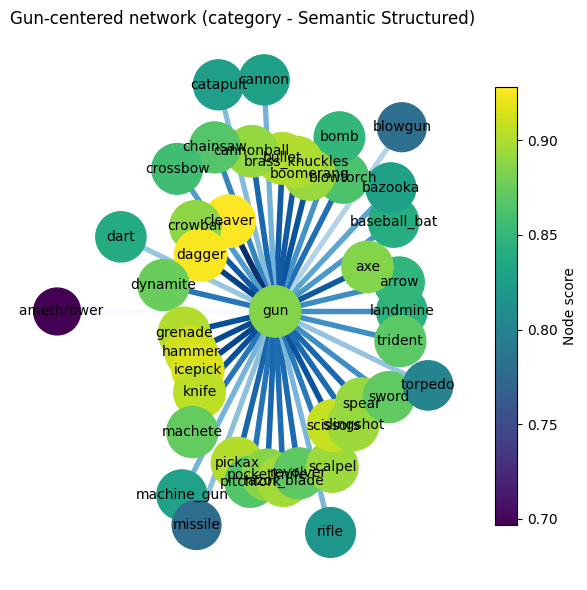

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# ---- Input data ----
center = "gun"

# ---- Split into node scores and pair scores ----
node_scores = {k: v for k, v in means.items() if "+" not in k}
pair_scores = {}
for k, v in means.items():
    if "+" in k:
        a, b = k.split("+")
        pair_scores[(a, b)] = v

# ---- Build the graph ----
G = nx.Graph()

# Add nodes with their scores
for node, score in node_scores.items():
    G.add_node(node, score=score)

# Add edges with weights (combination scores)
for (a, b), score in pair_scores.items():
    # Only add if both endpoints exist as nodes
    if a in G.nodes and b in G.nodes:
        G.add_edge(a, b, weight=score)

# ---- Compute positions ----
positions = {}

# Center node fixed at origin
positions[center] = (0.0, 0.0)

other_nodes = [n for n in node_scores.keys() if n != center]
n_others = len(other_nodes)
angles = np.linspace(0, 2 * np.pi, n_others, endpoint=False)

# Choose a global scale so distances are visible
R_MAX = 2.0  # you can tweak this

for angle, node in zip(angles, other_nodes):
    # Get edge score between center and this node
    edge_score = None
    if (center, node) in pair_scores:
        edge_score = pair_scores[(center, node)]
    elif (node, center) in pair_scores:
        edge_score = pair_scores[(node, center)]

    # If we have an edge score, map "similarity" (0–1) to distance
    # higher score => smaller distance
    if edge_score is not None:
        r = (1.0 - edge_score) * R_MAX
    else:
        # Fallback if no edge score (put it on outer ring)
        r = R_MAX

    x = r * np.cos(angle)
    y = r * np.sin(angle)
    positions[node] = (x, y)

# ---- Prepare style: node sizes/colors, edge widths/colors ----
node_scores_list = [G.nodes[n]["score"] for n in G.nodes()]
node_sizes = [300 + 1200 * s for s in node_scores_list]  # scale size by score
node_colors = node_scores_list

edge_weights = [G.edges[e]["weight"] for e in G.edges()]
edge_widths = [0.5 + 4 * w for w in edge_weights]

# ---- Draw ----
fig, ax = plt.subplots(figsize=(6, 6))

# Nodes
nodes = nx.draw_networkx_nodes(
    G,
    positions,
    node_size=node_sizes,
    node_color=node_colors,
    cmap="viridis",
    ax=ax
)

# Edges
edges = nx.draw_networkx_edges(
    G,
    positions,
    width=edge_widths,
    edge_color=edge_weights,
    edge_cmap=plt.cm.Blues,
    ax=ax
)

# Labels
nx.draw_networkx_labels(G, positions, font_size=10, ax=ax)

# Colorbar for node scores – explicitly tell it which axes to use
cbar_nodes = fig.colorbar(nodes, ax=ax, shrink=0.8)
cbar_nodes.set_label("Node score")

ax.set_axis_off()
ax.set_title("Gun-centered network (category - Semantic Structured)")
fig.tight_layout()
plt.show()

## Based on current exploration + Reflection
At this stage, I need to be explicit: I do not yet have a defensible “network analysis finding.” What I do have is a network-based way of seeing the problem that clarifies what kinds of claims will eventually be possible—and what kinds would be misleading right now.

Conceptually, a network representation makes a strong social/cultural statement: it treats meaning and memory as relational rather than purely intrinsic. If nodes are concepts/images and edges encode similarity, co-occurrence, or my combination score, then “memorability” can be interpreted as partly emerging from position in a semantic neighborhood: items might be memorable because they are distinctive relative to nearby items, or forgettable because they sit inside dense clusters where interference is likely. This matters culturally because the “neighborhood” is not just perceptual—it can reflect shared categories, media exposure, norms, and language conventions that determine which concepts commonly appear together and which contrasts feel salient.

However, with my current dataset (sparse tuples; limited concept groups), the graph structure is very likely to reflect measurement constraints rather than social structure. A community that appears in the visualization might be “real,” but it might also be an artifact of which pairs were sampled, which categories were overrepresented, or which concepts had enough observations to form edges at all. That’s why expanding the dataset is not just a technical improvement; it is a validity requirement before drawing cultural conclusions.

Still, the network attempt is productive because it shapes my next empirical move: once the data scale up, I can test whether semantic communities are stable across resampling and whether communities align with meaningful groupings (dataset categories, human-labeled semantics, or culturally grounded clusters). If stable, that would let me connect back to my research question in a socially interpretable way: not only “which images are memorable,” but which semantic regions of the concept space tend to be memorable/forgettable, and whether those regions correspond to culturally salient domains (people, weapons, food, status objects, etc.). Until then, the honest conclusion is that my current network is best framed as exploratory visualization and a roadmap toward later community-based analysis.

----

## Bibliography
Banna, T. T., Deb, S., Rahman, S., & Rahman, S. (2023). GEMM: A Graph Embedded Model for Memorability Prediction. 2023 International Joint Conference on Neural Networks (IJCNN), 1–8. https://doi.org/10.1109/IJCNN54540.2023.10191500

Dumont, T., Hevia, J. S., & Fosco, C. L. (2023). Modular Memorability: Tiered Representations for Video Memorability Prediction. 2023 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 10751–10760. https://doi.org/10.1109/CVPR52729.2023.01035

Xu, Q., Fang, F., Molino, A., Subbaraju, V., & Lim, J.-H. (2021). Predicting Event Memorability from Contextual Visual Semantics. Advances in Neural Information Processing Systems, 34, 22431–22442. https://proceedings.neurips.cc/paper_files/paper/2021/hash/bcc2bdb799f873f02080ae277f291da1-Abstract.html

